In [20]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


In [21]:
# Load preprocessed data
df_preprocessed = pd.read_csv('../data/processed/dht11_preprocessed.csv')

# Display first few rows of the data
df_preprocessed.head()


,datatime,temperature,humidity,mq2_analog,mq2_digital,sound_analog,sound_digital,mq9_analog,mq9_digital,mq8_analog,mq8_digital,pm25_density,pm10_density
0,2024-04-06 22:39:00,32.3,53.0,147.750000,1.0,187.625000,0.0,141.125000,1.0,205.125000,1.0,240.827500,247.057500
1,2024-04-06 22:40:00,32.3,53.0,147.777778,1.0,187.444444,0.0,142.000000,1.0,205.111111,1.0,241.173333,194.508889
2,2024-04-06 22:41:00,32.3,53.0,148.000000,1.0,188.375000,0.0,142.000000,1.0,205.250000,1.0,236.781250,209.391250
3,2024-04-06 22:42:00,32.3,53.0,147.555556,1.0,187.333333,0.0,141.111111,1.0,204.000000,1.0,241.542222,209.725556
4,2024-04-06 22:43:00,32.3,53.0,147.111111,1.0,186.777778,0.0,140.555556,1.0,203.000000,1.0,239.328889,198.197778


In [22]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Train the model using the preprocessed data (you can scale the data if needed)
# Assuming the df_preprocessed contains only the numerical features for anomaly detection
numeric_data = df_preprocessed.select_dtypes(include=['float64', 'int64'])

# Fit the Isolation Forest model
iso_forest.fit(numeric_data)

# Predict anomalies (1 means normal, -1 means anomaly)
df_preprocessed['anomaly_isolation_forest'] = iso_forest.predict(numeric_data)

# Show the rows with anomalies
anomalies_isolation = df_preprocessed[df_preprocessed['anomaly_isolation_forest'] == -1]

# Display the anomalies detected by Isolation Forest
print(f"Anomalies detected by Isolation Forest: {len(anomalies_isolation)}")
anomalies_isolation.head()


Anomalies detected by Isolation Forest: 297


,datatime,temperature,humidity,mq2_analog,mq2_digital,sound_analog,sound_digital,mq9_analog,mq9_digital,mq8_analog,mq8_digital,pm25_density,pm10_density,anomaly_isolation_forest
26,2024-04-06 23:20:00,32.3,55.0,352.0,1.0,314.5,0.0,409.0,1.0,502.5,1.0,185.425,-0.10,-1
27,2024-04-06 23:21:00,32.4,55.0,351.0,1.0,247.0,0.0,385.0,1.0,476.0,1.0,277.980,-0.10,-1
28,2024-04-06 23:37:00,16.4,27.5,602.5,1.0,434.5,0.5,181.5,1.0,59.0,0.0,159.275,-0.10,-1
29,2024-04-06 23:38:00,32.8,55.0,211.0,1.0,271.0,0.0,294.0,1.0,44.0,0.0,-0.100,-0.10,-1
30,2024-04-06 23:52:00,32.3,55.0,81.0,1.0,247.0,0.0,115.0,1.0,15.0,0.0,199.120,1.56,-1


In [23]:
# Filter the relevant columns
important_columns = [
    'temperature', 'humidity', 'mq2_analog', 'sound_analog', 
     'mq9_analog', 'datatime', 'mq8_analog', 'pm25_density', 'pm10_density', 'anomaly_isolation_forest'
]

# Filter the dataframe to include only the important columns
df_important = anomalies_isolation[important_columns]

# Save the filtered dataframe to CSV
# df_important.to_csv('../data/processed/isolation.csv', index=False)

print("Filtered data saved successfully!")


Filtered data saved successfully!


In [24]:
# If you have a column like 'timestamp' or 'date', you can convert it as follows:
df_preprocessed['datatime'] = pd.to_datetime(df_preprocessed['datatime'])
df_preprocessed['datatime'] = df_preprocessed['datatime'].astype(int) / 10**9  


In [25]:
# Scale the data (features) for better LSTM performance
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_preprocessed.select_dtypes(include=['float64', 'int64']))


In [26]:
scaled_data

array([[0.00000000e+00, 7.95566502e-01, 6.38554217e-01, ...,
        2.99292125e-01, 4.29516267e-01, 1.00000000e+00],
       [3.03824852e-06, 7.95566502e-01, 6.38554217e-01, ...,
        2.99721736e-01, 3.38196023e-01, 1.00000000e+00],
       [6.07649703e-06, 7.95566502e-01, 6.38554217e-01, ...,
        2.94265672e-01, 3.64058949e-01, 1.00000000e+00],
       ...,
       [9.99993924e-01, 7.11822660e-01, 4.81927711e-01, ...,
        2.90328948e-01, 3.32907245e-01, 1.00000000e+00],
       [9.99996962e-01, 7.11822660e-01, 4.81927711e-01, ...,
        2.78871264e-01, 3.10149472e-01, 1.00000000e+00],
       [1.00000000e+00, 7.11822660e-01, 4.81927711e-01, ...,
        2.85745046e-01, 3.10950802e-01, 1.00000000e+00]])

In [27]:
def create_sequences(data, time_steps):
    
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Prepare sequences for LSTM
time_steps = 50
X, y = create_sequences(scaled_data, time_steps)

In [28]:
#LSTM Model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(units=32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train LSTM model
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

# Predict future values with LSTM
predicted_values = model.predict(X)

# Calculate prediction error (mean squared error)
prediction_error = np.mean((predicted_values - y) ** 2, axis=1)

# Define an error threshold for anomaly detection
error_threshold = np.percentile(prediction_error, 95)  # You can adjust the threshold as needed

# Ensure that the length of the prediction_error matches the length of df_preprocessed (starting from time_steps index)
df_preprocessed['anomaly_lstm'] = np.nan  # Initialize with NaN
df_preprocessed.iloc[time_steps:, df_preprocessed.columns.get_loc('anomaly_lstm')] = np.where(prediction_error > error_threshold, -1, 1)


Epoch 1/10


c:\Users\shiva\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.1596 - val_loss: 0.1517
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1512 - val_loss: 0.1517
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1509 - val_loss: 0.1516
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.1513 - val_loss: 0.1516
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1510 - val_loss: 0.1516
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1510 - val_loss: 0.1516
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1510 - val_loss: 0.1516
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1509 - val_loss: 0.1516
Epoch 9/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1511 - val_loss: 0.1516
Epoch 10/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.1513 - val_loss: 0.1515
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [29]:
# Combine LSTM and Isolation Forest results
df_preprocessed['combined_anomaly'] = np.where(
    (df_preprocessed['anomaly_lstm'] == -1) | (df_preprocessed['anomaly_isolation_forest'] == -1),
    -1, 1
)

# Display the anomalies detected by both methods
anomalies_combined = df_preprocessed[df_preprocessed['combined_anomaly'] == -1]

print(f"Anomalies detected by Combined Methods: {len(anomalies_combined)}")
anomalies_combined.head()

Anomalies detected by Combined Methods: 566


,datatime,temperature,humidity,mq2_analog,mq2_digital,sound_analog,sound_digital,mq9_analog,mq9_digital,mq8_analog,mq8_digital,pm25_density,pm10_density,anomaly_isolation_forest,anomaly_lstm,combined_anomaly
26,1.712446e+09,32.3,55.0,352.0,1.0,314.5,0.0,409.0,1.0,502.5,1.0,185.425,-0.10,-1,NaN,-1
27,1.712446e+09,32.4,55.0,351.0,1.0,247.0,0.0,385.0,1.0,476.0,1.0,277.980,-0.10,-1,NaN,-1
28,1.712447e+09,16.4,27.5,602.5,1.0,434.5,0.5,181.5,1.0,59.0,0.0,159.275,-0.10,-1,NaN,-1
29,1.712447e+09,32.8,55.0,211.0,1.0,271.0,0.0,294.0,1.0,44.0,0.0,-0.100,-0.10,-1,NaN,-1
30,1.712448e+09,32.3,55.0,81.0,1.0,247.0,0.0,115.0,1.0,15.0,0.0,199.120,1.56,-1,NaN,-1


In [30]:
import plotly.graph_objects as go

# Create a Plotly figure
fig = go.Figure()

# Add Temperature data as a line plot
fig.add_trace(go.Scatter(
    x=df_preprocessed['datatime'],
    y=df_preprocessed['temperature'],
    mode='lines',
    name='Temperature',
    line=dict(color='blue')
))

# Add anomalies detected by Isolation Forest (highlighting in red)
fig.add_trace(go.Scatter(
    x=df_preprocessed['datatime'][df_preprocessed['anomaly_isolation_forest'] == -1],
    y=df_preprocessed['temperature'][df_preprocessed['anomaly_isolation_forest'] == -1],
    mode='markers',
    name='Anomaly - Isolation Forest',
    marker=dict(color='red', symbol='x', size=10)
))

# Add anomalies detected by LSTM (highlighting in green)
fig.add_trace(go.Scatter(
    x=df_preprocessed['datatime'][df_preprocessed['anomaly_lstm'] == -1],
    y=df_preprocessed['temperature'][df_preprocessed['anomaly_lstm'] == -1],
    mode='markers',
    name='Anomaly - LSTM',
    marker=dict(color='green', symbol='x', size=10)
))

# Update layout for better presentation
fig.update_layout(
    title='Temperature Data with Anomalies Detected by Isolation Forest and LSTM',
    xaxis_title='Timestamp',
    yaxis_title='Temperature',
    hovermode='closest',
    template='plotly_dark'
)

# Show the interactive plot
fig.show()


In [31]:

# Convert 'datatime' to datetime format (assuming it's a UNIX timestamp)
df_preprocessed['datatime'] = pd.to_datetime(df_preprocessed['datatime'], unit='s')

# Add a group identifier for consecutive anomalies
df_preprocessed['anomaly_group'] = (df_preprocessed['combined_anomaly'] != -1).cumsum()

# Filter for anomaly rows and group by consecutive anomalies
anomalies = df_preprocessed[df_preprocessed['combined_anomaly'] == -1].groupby('anomaly_group')

# Calculate the duration for each group
anomaly_durations = anomalies['datatime'].agg(['min', 'max'])
anomaly_durations['anomaly_duration'] = (anomaly_durations['max'] - anomaly_durations['min']).dt.total_seconds()

# Merge the durations back into the original DataFrame
df_preprocessed = df_preprocessed.merge(
    anomaly_durations[['anomaly_duration']],
    how='left',
    left_on='anomaly_group',
    right_index=True
)

# Replace non-anomaly rows' durations with 0
df_preprocessed.loc[df_preprocessed['combined_anomaly'] != -1, 'anomaly_duration'] = 0

# Drop the temporary 'anomaly_group' column
df_preprocessed.drop(columns=['anomaly_group'], inplace=True)

# Display the updated DataFrame
df_preprocessed

,datatime,temperature,humidity,mq2_analog,mq2_digital,sound_analog,sound_digital,mq9_analog,mq9_digital,mq8_analog,mq8_digital,pm25_density,pm10_density,anomaly_isolation_forest,anomaly_lstm,combined_anomaly,anomaly_duration
0,2024-04-06 22:39:00,32.300000,53.0,147.750000,1.0,187.625000,0.0,141.125000,1.0,205.125000,1.0,240.827500,247.057500,1,NaN,1,0.0
1,2024-04-06 22:40:00,32.300000,53.0,147.777778,1.0,187.444444,0.0,142.000000,1.0,205.111111,1.0,241.173333,194.508889,1,NaN,1,0.0
2,2024-04-06 22:41:00,32.300000,53.0,148.000000,1.0,188.375000,0.0,142.000000,1.0,205.250000,1.0,236.781250,209.391250,1,NaN,1,0.0
3,2024-04-06 22:42:00,32.300000,53.0,147.555556,1.0,187.333333,0.0,141.111111,1.0,204.000000,1.0,241.542222,209.725556,1,NaN,1,0.0
4,2024-04-06 22:43:00,32.300000,53.0,147.111111,1.0,186.777778,0.0,140.555556,1.0,203.000000,1.0,239.328889,198.197778,1,NaN,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5921,2024-11-21 12:12:00,28.755556,40.0,47.777778,1.0,143.111111,0.0,231.111111,1.0,139.444444,1.0,216.365556,171.730000,1,1.0,1,0.0
5922,2024-11-21 12:13:00,28.900000,40.0,47.750000,1.0,143.500000,0.0,231.250000,1.0,139.625000,1.0,228.482500,179.511250,1,1.0,1,0.0
5923,2024-11-21 12:14:00,28.900000,40.0,48.000000,1.0,143.111111,0.0,231.777778,1.0,139.888889,1.0,233.612222,191.465556,1,1.0,1,0.0
5924,2024-11-21 12:15:00,28.900000,40.0,48.000000,1.0,141.888889,0.0,230.222222,1.0,140.000000,1.0,224.388889,178.370000,1,1.0,1,0.0


In [32]:
# df_preprocessed.to_csv("../data/processed/new_dht11_preprocessed.csv", index=False)


In [33]:
# Print the unique values and their frequencies 
print(df_preprocessed['combined_anomaly'].value_counts())

combined_anomaly
 1    5360
-1     566
Name: count, dtype: int64


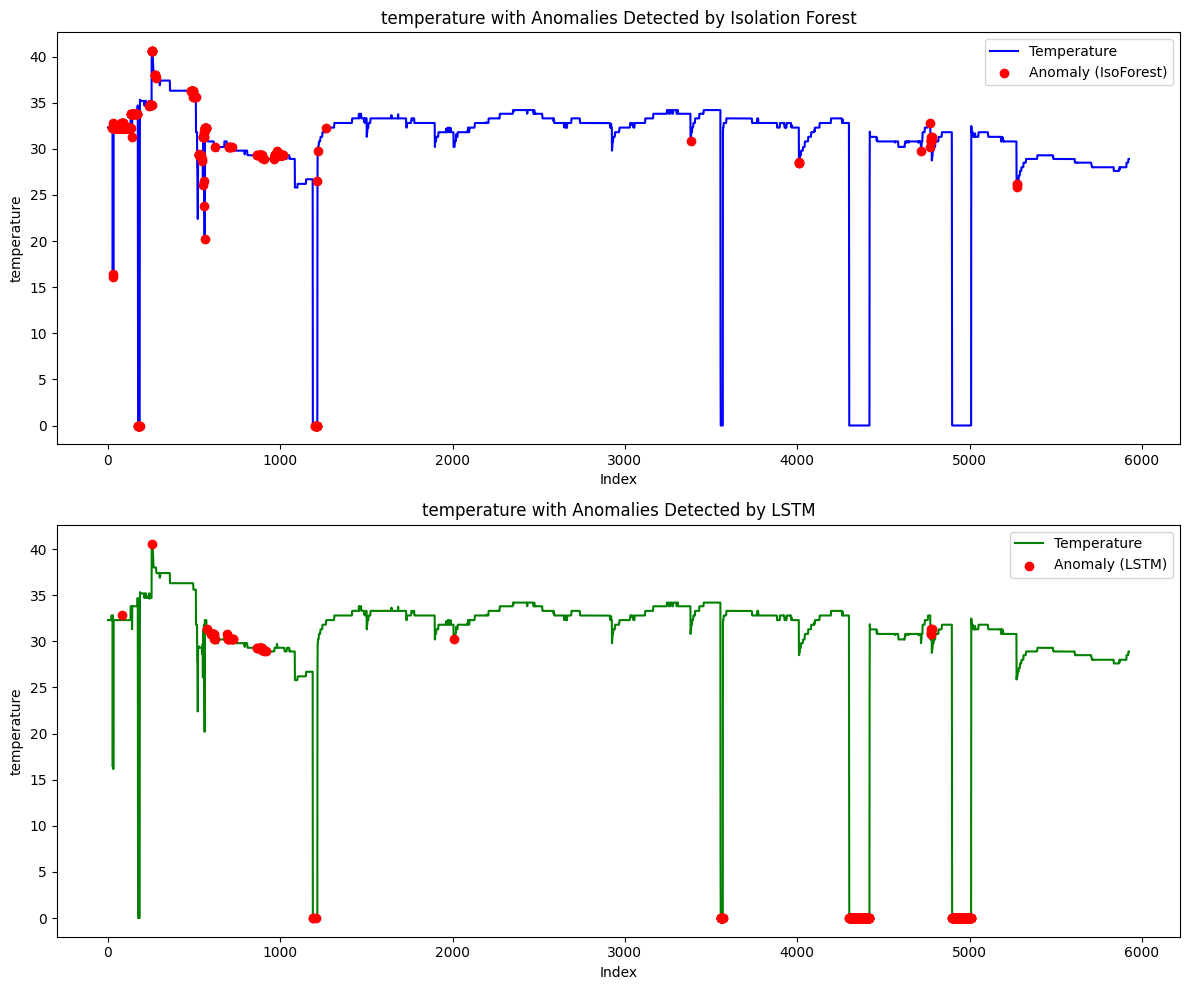

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a feature to visualize, for example, 'temperature'
feature = 'temperature'

# Filter the first 100 records for visualization
df_subset = df_preprocessed

# Create a new figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot for Isolation Forest anomalies
ax1.plot(df_subset[feature], color='b', label='Temperature')  # Line plot for temperature
ax1.scatter(df_subset.index[df_subset['anomaly_isolation_forest'] == -1], 
            df_subset[feature][df_subset['anomaly_isolation_forest'] == -1], 
            color='r', label='Anomaly (IsoForest)', zorder=5)  # Mark anomalies with red dots
ax1.set_title(f'{feature} with Anomalies Detected by Isolation Forest')
ax1.set_xlabel('Index')
ax1.set_ylabel(f'{feature}')
ax1.legend()

# Plot for LSTM anomalies
ax2.plot(df_subset[feature], color='g', label='Temperature')  # Line plot for temperature
ax2.scatter(df_subset.index[df_subset['anomaly_lstm'] == -1], 
            df_subset[feature][df_subset['anomaly_lstm'] == -1], 
            color='r', label='Anomaly (LSTM)', zorder=5)  # Mark anomalies with red dots
ax2.set_title(f'{feature} with Anomalies Detected by LSTM')
ax2.set_xlabel('Index')
ax2.set_ylabel(f'{feature}')
ax2.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [35]:
# Calculate Total Combined Anomalies
total_data_points = len(df_preprocessed)
total_combined_anomalies = len(df_preprocessed[df_preprocessed['combined_anomaly'] == -1])
combined_anomalies_percentage = (total_combined_anomalies / total_data_points) * 100

print(f"Total Combined Anomalies: {total_combined_anomalies} ({combined_anomalies_percentage:.2f}%)")

# Calculate Isolation Forest Anomalies
isolation_anomalies_count = len(df_preprocessed[df_preprocessed['anomaly_isolation_forest'] == -1])
isolation_anomalies_percentage = (isolation_anomalies_count / total_data_points) * 100

print(f"Anomalies Detected by Isolation Forest: {isolation_anomalies_count} ({isolation_anomalies_percentage:.2f}%)")

# Calculate LSTM Anomalies
lstm_anomalies_count = len(df_preprocessed[df_preprocessed['anomaly_lstm'] == -1])
lstm_anomalies_percentage = (lstm_anomalies_count / total_data_points) * 100

print(f"Anomalies Detected by LSTM: {lstm_anomalies_count} ({lstm_anomalies_percentage:.2f}%)")

# Calculate Similarity (Overlap) Between Isolation Forest and LSTM
overlap_count = len(
    df_preprocessed[
        (df_preprocessed['anomaly_isolation_forest'] == -1) & (df_preprocessed['anomaly_lstm'] == -1)
    ]
)
overlap_percentage = (overlap_count / total_combined_anomalies) * 100

print(f"Overlap Between Models: {overlap_count} ({overlap_percentage:.2f}%)")


Total Combined Anomalies: 566 (9.55%)
Anomalies Detected by Isolation Forest: 297 (5.01%)
Anomalies Detected by LSTM: 294 (4.96%)
Overlap Between Models: 25 (4.42%)


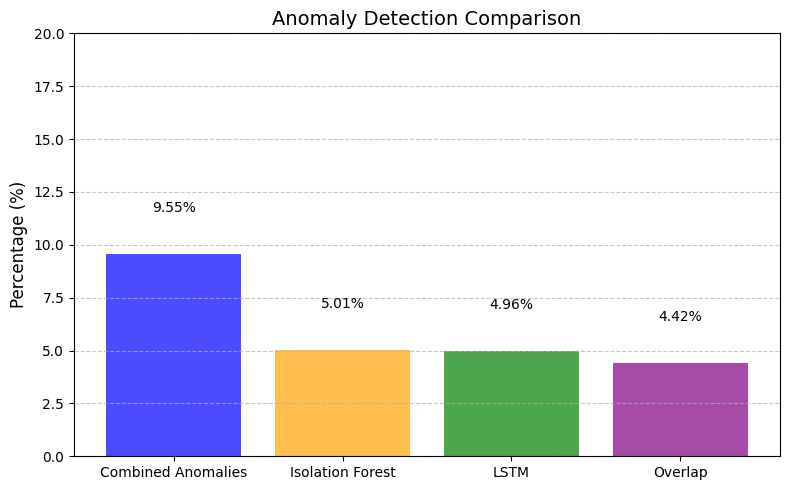

In [40]:
import matplotlib.pyplot as plt

# Data for visualization
categories = ['Combined Anomalies', 'Isolation Forest', 'LSTM', 'Overlap']
values = [
    combined_anomalies_percentage,
    isolation_anomalies_percentage,
    lstm_anomalies_percentage,
    overlap_percentage
]

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['blue', 'orange', 'green', 'purple'], alpha=0.7)
plt.title('Anomaly Detection Comparison', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=12)
plt.ylim(0, 20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Annotate values on the bars
for i, v in enumerate(values):
    plt.text(i, v + 2, f"{v:.2f}%", ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()


In [41]:
# List of all parameters to visualize, excluding digital and time-related columns
parameters = ['temperature', 'humidity', 'mq2_analog', 'mq9_analog', 'mq8_analog', 
              'sound_analog', 'pm25_density', 'pm10_density']

# Iterate through each parameter and create a graph
for param in parameters:
    # Create a Plotly figure
    fig = go.Figure()

    # Add the parameter data as a line plot
    fig.add_trace(go.Scatter(
        x=df_preprocessed['datatime'],
        y=df_preprocessed[param],
        mode='lines',
        name=param.capitalize(),
        line=dict(color='blue')
    ))

    # Add anomalies detected by Isolation Forest (highlighting in red)
    fig.add_trace(go.Scatter(
        x=df_preprocessed['datatime'][df_preprocessed['anomaly_isolation_forest'] == -1],
        y=df_preprocessed[param][df_preprocessed['anomaly_isolation_forest'] == -1],
        mode='markers',
        name=f'Anomaly - Isolation Forest ({param})',
        marker=dict(color='red', symbol='x', size=10)
    ))

    # Add anomalies detected by LSTM (highlighting in green)
    fig.add_trace(go.Scatter(
        x=df_preprocessed['datatime'][df_preprocessed['anomaly_lstm'] == -1],
        y=df_preprocessed[param][df_preprocessed['anomaly_lstm'] == -1],
        mode='markers',
        name=f'Anomaly - LSTM ({param})',
        marker=dict(color='green', symbol='x', size=10)
    ))

    # Update layout for better presentation
    fig.update_layout(
        title=f'{param.capitalize()} Data with Anomalies Detected by Isolation Forest and LSTM',
        xaxis_title='Timestamp',
        yaxis_title=param.capitalize(),
        hovermode='closest',
        # template='plotly_dark'
    )

    # Show the interactive plot for the current parameter
    fig.show()


In [38]:
import plotly.io as pio

# Ensure you have the necessary dependencies installed


# Directory to save the plots
output_dir = "plots/"
import os

# Create directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# List of all parameters to visualize, excluding digital and time-related columns
parameters = ['temperature', 'humidity', 'mq2_analog', 'mq9_analog', 'mq8_analog', 
              'sound_analog', 'pm25_density', 'pm10_density']

# Iterate through each parameter and create a graph
for param in parameters:
    # Create a Plotly figure
    fig = go.Figure()

    # Add the parameter data as a line plot
    fig.add_trace(go.Scatter(
        x=df_preprocessed['datatime'],
        y=df_preprocessed[param],
        mode='lines',
        name=param.capitalize(),
        line=dict(color='blue')
    ))

    # Add anomalies detected by Isolation Forest (highlighting in red)
    fig.add_trace(go.Scatter(
        x=df_preprocessed['datatime'][df_preprocessed['anomaly_isolation_forest'] == -1],
        y=df_preprocessed[param][df_preprocessed['anomaly_isolation_forest'] == -1],
        mode='markers',
        name=f'Anomaly - Isolation Forest ({param})',
        marker=dict(color='red', symbol='x', size=10)
    ))

    # Add anomalies detected by LSTM (highlighting in green)
    fig.add_trace(go.Scatter(
        x=df_preprocessed['datatime'][df_preprocessed['anomaly_lstm'] == -1],
        y=df_preprocessed[param][df_preprocessed['anomaly_lstm'] == -1],
        mode='markers',
        name=f'Anomaly - LSTM ({param})',
        marker=dict(color='green', symbol='x', size=10)
    ))

    # Update layout for better presentation
    fig.update_layout(
        title=f'{param.capitalize()} Data with Anomalies Detected by Isolation Forest and LSTM',
        xaxis_title='Timestamp',
        yaxis_title=param.capitalize(),
        hovermode='closest',
        # template='plotly_dark'
    )

    # Filepath for the current plot
    file_path = os.path.join(output_dir, f"{param}_anomalies_plot.png")

    # Save the plot as a PNG file with increased width and height
    fig.write_image(file_path, width=2000, height=800)

    # Optionally, display the plot
    # fig.show()

print(f"All plots have been saved in the '{output_dir}' directory.")


All plots have been saved in the 'plots/' directory.
